Objective: 
Predict whether a Patient will have cardiac_arrest or not based on some given attributes. Evaluation metric taken is AUC-ROC Score

Understanding Data

id-Patient ID

gender-Gender of Patient

age-Age of Patient

hypertension-0 - no hypertension, 1 - suffering from hypertension

heart_disease-0 - no heart disease, 1 - suffering from heart disease

ever_married-Yes/No

work_type-Type of occupation

Residence_type-Area type of residence (Urban/ Rural)

avg_glucose_level-Average Glucose level (measured after meal)

bmi-Body mass index

smoking_status-patient’s smoking status

Target column - suffered cardiac arrest-0 - didn't suffer cardiac arrest- 1

In [1]:
!pip install pyspark

     |████████████████████████████████| 204.2MB 57kB/s 
     |████████████████████████████████| 204kB 46.0MB/s 
  Created wheel for pyspark: filename=pyspark-3.0.1-py2.py3-none-any.whl size=204612242 sha256=fe7eecdb14585cb7ee23224094cceaf940d598e46806354d298aa4f1c398c9f5
  Stored in directory: /root/.cache/pip/wheels/5e/bd/07/031766ca628adec8435bb40f0bd83bb676ce65ff4007f8e73f
Successfully built pyspark


In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
from pyspark.sql import SparkSession
spark= SparkSession.builder.appName("spark").getOrCreate()

In [4]:
sc = spark.sparkContext
sc

<SparkContext master=local[*] appName=spark>

Data Fetching

In [5]:
!git clone https://github.com/SanKalp4/PySpark/

Cloning into 'PySpark'...
remote: Enumerating objects: 14, done.
remote: Counting objects: 100% (14/14), done.
remote: Compressing objects: 100% (12/12), done.
remote: Total 14 (delta 3), reused 0 (delta 0), pack-reused 0
Unpacking objects: 100% (14/14), done.


In [6]:
df= spark.read.csv('/content/PySpark/heart health cardiac_arrest-data.csv',header= True, inferSchema= True)

Objective
Predict whether a Patient will have cardiac_arrest or not based on some given attributes. Evaluation metric was AUC-ROC Score

In [7]:
df.show()

+-----+------+----+------------+-------------+------------+-------------+--------------+-----------------+----+---------------+--------------+
|   id|gender| age|hypertension|heart_disease|ever_married|    work_type|Residence_type|avg_glucose_level| bmi| smoking_status|cardiac_arrest|
+-----+------+----+------------+-------------+------------+-------------+--------------+-----------------+----+---------------+--------------+
| 9046|  Male|67.0|           0|            1|         Yes|      Private|         Urban|           228.69|36.6|formerly smoked|             1|
|51676|Female|61.0|           0|            0|         Yes|Self-employed|         Rural|           202.21| N/A|   never smoked|             1|
|31112|  Male|80.0|           0|            1|         Yes|      Private|         Rural|           105.92|32.5|   never smoked|             1|
|60182|Female|49.0|           0|            0|         Yes|      Private|         Urban|           171.23|34.4|         smokes|             1|

In [8]:
df.dtypes

[('id', 'int'),
 ('gender', 'string'),
 ('age', 'double'),
 ('hypertension', 'int'),
 ('heart_disease', 'int'),
 ('ever_married', 'string'),
 ('work_type', 'string'),
 ('Residence_type', 'string'),
 ('avg_glucose_level', 'double'),
 ('bmi', 'string'),
 ('smoking_status', 'string'),
 ('cardiac_arrest', 'int')]

In [9]:
df.printSchema()

root
 |-- id: integer (nullable = true)
 |-- gender: string (nullable = true)
 |-- age: double (nullable = true)
 |-- hypertension: integer (nullable = true)
 |-- heart_disease: integer (nullable = true)
 |-- ever_married: string (nullable = true)
 |-- work_type: string (nullable = true)
 |-- Residence_type: string (nullable = true)
 |-- avg_glucose_level: double (nullable = true)
 |-- bmi: string (nullable = true)
 |-- smoking_status: string (nullable = true)
 |-- cardiac_arrest: integer (nullable = true)



In [10]:
print(df.count(),len(df.columns))

5110 12


# Data Cleaning & Preprocessing



In [11]:
#checking Null values

df.toPandas().isnull().sum()

id                   0
gender               0
age                  0
hypertension         0
heart_disease        0
ever_married         0
work_type            0
Residence_type       0
avg_glucose_level    0
bmi                  0
smoking_status       0
cardiac_arrest       0
dtype: int64

In [12]:
# fill in N/A values with mean for feature "bmi"

from pyspark.sql.functions import *
df = df.withColumn('bmi', translate('bmi', 'N/A', '28.9')) 
df.show()

+-----+------+----+------------+-------------+------------+-------------+--------------+-----------------+----+---------------+--------------+
|   id|gender| age|hypertension|heart_disease|ever_married|    work_type|Residence_type|avg_glucose_level| bmi| smoking_status|cardiac_arrest|
+-----+------+----+------------+-------------+------------+-------------+--------------+-----------------+----+---------------+--------------+
| 9046|  Male|67.0|           0|            1|         Yes|      Private|         Urban|           228.69|36.6|formerly smoked|             1|
|51676|Female|61.0|           0|            0|         Yes|Self-employed|         Rural|           202.21| 28.|   never smoked|             1|
|31112|  Male|80.0|           0|            1|         Yes|      Private|         Rural|           105.92|32.5|   never smoked|             1|
|60182|Female|49.0|           0|            0|         Yes|      Private|         Urban|           171.23|34.4|         smokes|             1|

In [13]:
df = df.withColumn("bmi", df["bmi"].cast("double")) #converting bmi as string to double
df.printSchema()

root
 |-- id: integer (nullable = true)
 |-- gender: string (nullable = true)
 |-- age: double (nullable = true)
 |-- hypertension: integer (nullable = true)
 |-- heart_disease: integer (nullable = true)
 |-- ever_married: string (nullable = true)
 |-- work_type: string (nullable = true)
 |-- Residence_type: string (nullable = true)
 |-- avg_glucose_level: double (nullable = true)
 |-- bmi: double (nullable = true)
 |-- smoking_status: string (nullable = true)
 |-- cardiac_arrest: integer (nullable = true)



# EDA

In [14]:
df.groupby('cardiac_arrest').count().show()

+--------------+-----+
|cardiac_arrest|count|
+--------------+-----+
|             1|  249|
|             0| 4861|
+--------------+-----+



*Data is imbalanced where the number of people who had cardiac arrest is significantly higher than those who didnt had.*



In [15]:
# create DataFrame as a temporary view
df.createOrReplaceTempView('table')

In [16]:
spark.sql('Select cardiac_arrest, count(cardiac_arrest), count(cardiac_arrest)*100 /sum(count(cardiac_arrest)) over() \
as percent from table group by cardiac_arrest').show()

+--------------+---------------------+-----------------+
|cardiac_arrest|count(cardiac_arrest)|          percent|
+--------------+---------------------+-----------------+
|             1|                  249| 4.87279843444227|
|             0|                 4861|95.12720156555773|
+--------------+---------------------+-----------------+



In [17]:
spark.sql("SELECT gender, count(gender) as count_gender, count(gender)*100/sum(count(gender)) over() \
 as percent  FROM table GROUP BY gender").show()

+------+------------+--------------------+
|gender|count_gender|             percent|
+------+------------+--------------------+
|Female|        2994|  58.590998043052835|
| Other|           1|0.019569471624266144|
|  Male|        2115|    41.3894324853229|
+------+------------+--------------------+



Study participants segregated age wise


In [18]:
spark.sql("SELECT hypertension, count(hypertension) as hypertension_count FROM table WHERE cardiac_arrest == 1 GROUP BY hypertension \
ORDER BY hypertension_count DESC").show()

+------------+------------------+
|hypertension|hypertension_count|
+------------+------------------+
|           0|               183|
|           1|                66|
+------------+------------------+



In [19]:
spark.sql("SELECT ever_married, count(ever_married) as married_count FROM table WHERE cardiac_arrest == 1 GROUP BY ever_married \
ORDER BY ever_married DESC").show()

+------------+-------------+
|ever_married|married_count|
+------------+-------------+
|         Yes|          220|
|          No|           29|
+------------+-------------+



In [20]:
spark.sql("SELECT Residence_type, count(Residence_type) as urban_rural_count FROM table WHERE cardiac_arrest == 1 GROUP BY Residence_type \
ORDER BY Residence_type DESC").show()

+--------------+-----------------+
|Residence_type|urban_rural_count|
+--------------+-----------------+
|         Urban|              135|
|         Rural|              114|
+--------------+-----------------+



urban:rural ratio


In [21]:
spark.sql("SELECT work_type, count(work_type) as work_type_count FROM table WHERE cardiac_arrest == 1 GROUP BY work_type \
ORDER BY work_type_count DESC").show()

+-------------+---------------+
|    work_type|work_type_count|
+-------------+---------------+
|      Private|            149|
|Self-employed|             65|
|     Govt_job|             33|
|     children|              2|
+-------------+---------------+



As per data ,Private job leads 
to higher amount of cardiac_arrest


In [22]:
spark.sql("SELECT gender, count(gender), (COUNT(gender) * 100.0) /(SELECT count(gender) FROM table WHERE gender = 'Male') as \
percentage FROM table WHERE cardiac_arrest = '1' and gender = 'Male' GROUP BY gender").show()

+------+-------------+----------------+
|gender|count(gender)|      percentage|
+------+-------------+----------------+
|  Male|          108|5.10638297872340|
+------+-------------+----------------+



5.1% of total male in the sample data have had a cardiac arrest


In [23]:
spark.sql("SELECT gender, count(gender), (COUNT(gender) * 100.0) /(SELECT count(gender) FROM table WHERE gender = 'Female') as \
percentage FROM table WHERE cardiac_arrest = '1' and gender= 'Female' GROUP BY gender").show()

+------+-------------+----------------+
|gender|count(gender)|      percentage|
+------+-------------+----------------+
|Female|          141|4.70941883767535|
+------+-------------+----------------+



4.7% of total female in the sample data have had a cardiac arrest.

In [24]:
spark.sql("SELECT age, count(age) as age_count FROM table WHERE cardiac_arrest == 1 GROUP BY age ORDER BY age_count DESC").show()

+----+---------+
| age|age_count|
+----+---------+
|78.0|       21|
|79.0|       17|
|80.0|       17|
|81.0|       14|
|57.0|       11|
|76.0|       10|
|68.0|        9|
|63.0|        9|
|82.0|        9|
|74.0|        9|
|59.0|        8|
|77.0|        8|
|71.0|        7|
|58.0|        7|
|72.0|        6|
|75.0|        6|
|70.0|        6|
|61.0|        6|
|69.0|        6|
|54.0|        6|
+----+---------+
only showing top 20 rows



Agewise cardiac arrest risk. can be concluded people in age bracket 60-80 have higher risk

In [25]:
df.filter((df['cardiac_arrest'] == 1) & (df['age'] > '60')).count()

177

Cardiac arrest happened to 177 out of 5110 people who are above 60


In [26]:
spark.sql("SELECT bmi, count(bmi) as bmi_count FROM table WHERE cardiac_arrest == 1 GROUP BY bmi ORDER BY bmi_count DESC").show()

+----+---------+
| bmi|bmi_count|
+----+---------+
|28.0|       43|
|31.4|        5|
|27.3|        5|
|24.0|        4|
|27.7|        3|
|36.5|        3|
|28.5|        3|
|27.5|        3|
|32.0|        3|
|29.7|        3|
|28.4|        3|
|26.6|        3|
|31.1|        3|
|24.2|        3|
|30.9|        3|
|31.7|        3|
|26.4|        3|
|31.0|        3|
|29.9|        3|
|27.4|        2|
+----+---------+
only showing top 20 rows



In [27]:
spark.sql("SELECT smoking_status, count(smoking_status) as smoking_status, count(smoking_status)*100/sum(count(smoking_status)) over() \
 as percent  FROM table GROUP BY smoking_status").show()

+---------------+--------------+------------------+
| smoking_status|smoking_status|           percent|
+---------------+--------------+------------------+
|         smokes|           789|15.440313111545988|
|        Unknown|          1544| 30.21526418786693|
|   never smoked|          1892|37.025440313111545|
|formerly smoked|           885| 17.31898238747554|
+---------------+--------------+------------------+



Visualisation with sns and matplotlib


In [28]:
sample_df = df.sample(1.0).toPandas()

/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


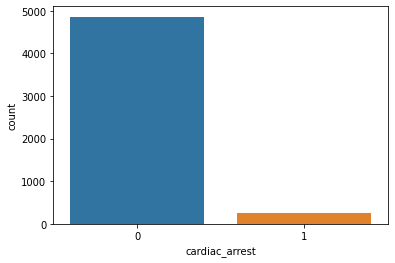

In [29]:
sns.countplot(sample_df['cardiac_arrest'] )

/usr/local/lib/python3.6/dist-packages/seaborn/categorical.py:1296: UserWarning: 69.0% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


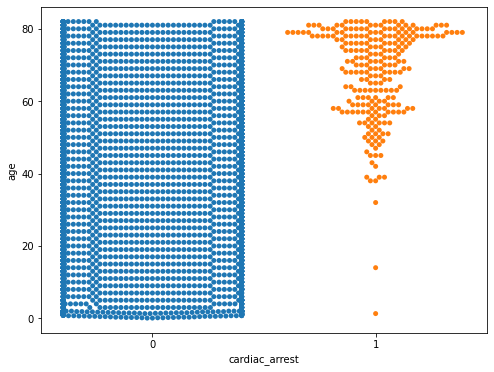

In [30]:
plt.figure(figsize=(8,6))
sns.swarmplot(y = sample_df.age, x=  sample_df.cardiac_arrest)

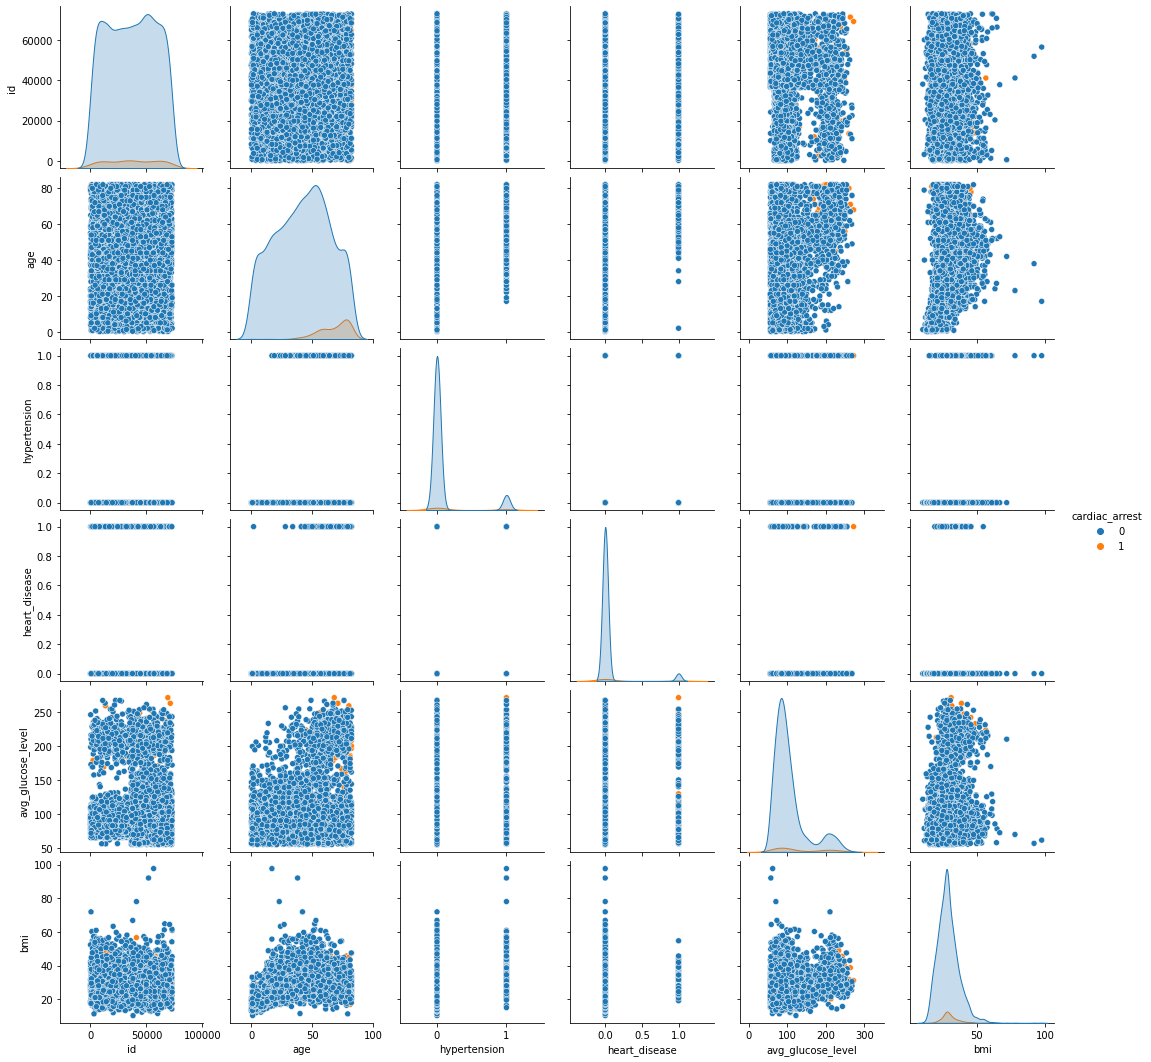

In [31]:
sns.pairplot(sample_df, hue=  'cardiac_arrest')

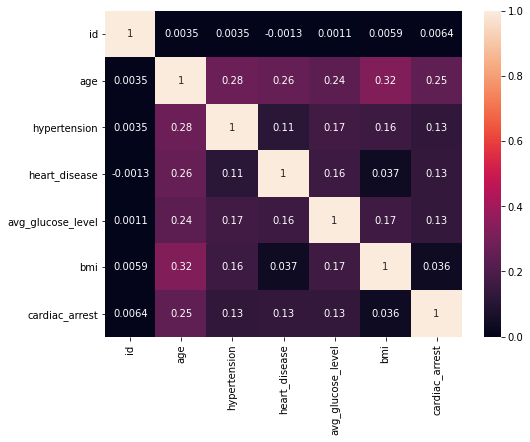

In [32]:
plt.figure(figsize= (8,6))
sns.heatmap(sample_df.corr(),annot=True)

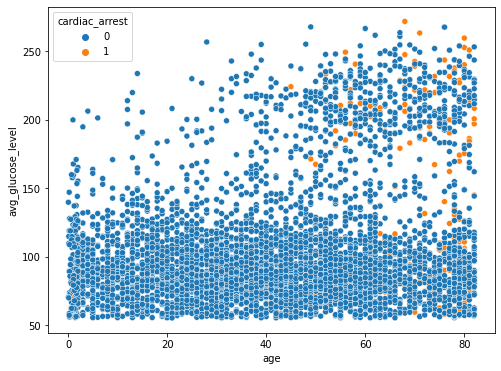

In [33]:
plt.figure(figsize= (8,6))
sns.scatterplot(x = 'age', y = 'avg_glucose_level', data = sample_df , hue= 'cardiac_arrest')

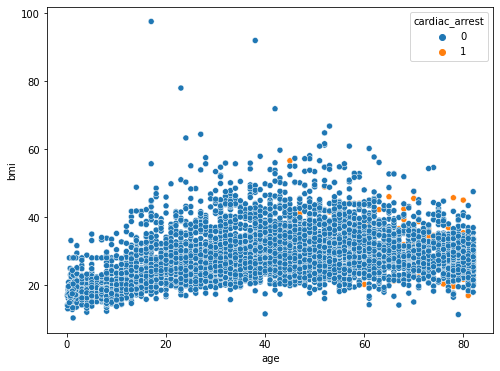

In [34]:
plt.figure(figsize= (8,6))
sns.scatterplot(x = 'age', y = 'bmi', data = sample_df , hue= 'cardiac_arrest')

# Data Processing

In [35]:
df= df.drop('id')

IMBALANCE TREATMENT USING SMOTE

In [36]:
from pyspark.ml import Pipeline
from pyspark.ml.feature import StringIndexer

categorical_columns= ["gender", "ever_married","work_type","Residence_type","smoking_status"]
numeric_col= ['age', 'hypertension','heart_disease','avg_glucose_level','bmi','cardiac_arrest']

# The index of string values multiple columns
indexers = [
    StringIndexer(inputCol=c, outputCol="{0}_indexed".format(c))
    for c in categorical_columns
]


pipeline = Pipeline(stages=indexers )
df_r = pipeline.fit(df).transform(df)

df_r.show()

+------+----+------------+-------------+------------+-------------+--------------+-----------------+----+---------------+--------------+--------------+--------------------+-----------------+----------------------+----------------------+
|gender| age|hypertension|heart_disease|ever_married|    work_type|Residence_type|avg_glucose_level| bmi| smoking_status|cardiac_arrest|gender_indexed|ever_married_indexed|work_type_indexed|Residence_type_indexed|smoking_status_indexed|
+------+----+------------+-------------+------------+-------------+--------------+-----------------+----+---------------+--------------+--------------+--------------------+-----------------+----------------------+----------------------+
|  Male|67.0|           0|            1|         Yes|      Private|         Urban|           228.69|36.6|formerly smoked|             1|           1.0|                 0.0|              0.0|                   0.0|                   2.0|
|Female|61.0|           0|            0|         Yes

In [37]:
from imblearn.over_sampling import SMOTE
#from imblearn.combine import SMOTEENN
from sklearn.model_selection import train_test_split
from collections import Counter

X = df_r.toPandas().filter(items=['gender_indexed','age','hypertension','heart_disease','ever_married_indexed','work_type_indexed','Residence_type_indexed','avg_glucose_level','bmi','smoking_status_indexed'])
Y = df_r.toPandas().filter(items=['cardiac_arrest'])
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.1, random_state=0)

sm = SMOTE(random_state=12, ratio = 'auto', kind = 'regular')
x_train_res, y_train_res = sm.fit_sample(X_train, Y_train)
print('Resampled dataset shape {}'.format(Counter(y_train_res)))



/usr/local/lib/python3.6/dist-packages/sklearn/externals/six.py:31: FutureWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.neighbors.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from sklearn.neighbors is now part of the private API.
  warnings.warn(message, FutureWarning)


Resampled dataset shape Counter({0: 4380, 1: 4380})


/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


In [38]:
dataframe_1 = pd.DataFrame(x_train_res,columns=['gender_indexed','age','hypertension','heart_disease','ever_married_indexed','work_type_indexed','Residence_type_indexed','avg_glucose_level','bmi','smoking_status_indexed'])
dataframe_2 = pd.DataFrame(y_train_res, columns = ['cardiac_arrest'])
# frames = [dataframe_1, dataframe_2]

result = dataframe_1.combine_first(dataframe_2)


df_smoted = spark.createDataFrame(result)

In [39]:
df_smoted.createOrReplaceTempView('table1')
spark.sql('Select cardiac_arrest, count(cardiac_arrest), count(cardiac_arrest)*100 /sum(count(cardiac_arrest)) over() \
as percent from table1 group by cardiac_arrest').show()

+--------------+---------------------+-------+
|cardiac_arrest|count(cardiac_arrest)|percent|
+--------------+---------------------+-------+
|           0.0|                 4380|   50.0|
|           1.0|                 4380|   50.0|
+--------------+---------------------+-------+



          Balanced class after applying SMOTE.

In [40]:
df_smoted.show()

+----------------------+----+-----------------+----+--------------+--------------------+--------------+-------------+------------+----------------------+-----------------+
|Residence_type_indexed| age|avg_glucose_level| bmi|cardiac_arrest|ever_married_indexed|gender_indexed|heart_disease|hypertension|smoking_status_indexed|work_type_indexed|
+----------------------+----+-----------------+----+--------------+--------------------+--------------+-------------+------------+----------------------+-----------------+
|                   0.0|55.0|            92.59|36.6|           0.0|                 0.0|           1.0|          0.0|         0.0|                   0.0|              3.0|
|                   0.0|54.0|           141.37|23.5|           0.0|                 0.0|           1.0|          0.0|         0.0|                   0.0|              0.0|
|                   1.0|82.0|             58.3|20.4|           0.0|                 0.0|           0.0|          0.0|         0.0|          

In [41]:
#reordering
df_smote = df_smoted.select('gender_indexed','age','hypertension','heart_disease','ever_married_indexed','work_type_indexed','Residence_type_indexed','avg_glucose_level','bmi','smoking_status_indexed','cardiac_arrest')
df_smote.show()


+--------------+----+------------+-------------+--------------------+-----------------+----------------------+-----------------+----+----------------------+--------------+
|gender_indexed| age|hypertension|heart_disease|ever_married_indexed|work_type_indexed|Residence_type_indexed|avg_glucose_level| bmi|smoking_status_indexed|cardiac_arrest|
+--------------+----+------------+-------------+--------------------+-----------------+----------------------+-----------------+----+----------------------+--------------+
|           1.0|55.0|         0.0|          0.0|                 0.0|              3.0|                   0.0|            92.59|36.6|                   0.0|           0.0|
|           1.0|54.0|         0.0|          0.0|                 0.0|              0.0|                   0.0|           141.37|23.5|                   0.0|           0.0|
|           0.0|82.0|         0.0|          0.0|                 0.0|              3.0|                   1.0|             58.3|20.4|       

In [42]:
print(df_smote.count(),len(df_smote.columns))

8760 11


In [43]:
from pyspark.ml import Pipeline
from pyspark.ml.feature import StringIndexer, OneHotEncoder, VectorAssembler


categorical_columns= ["gender_indexed",'hypertension','heart_disease', "ever_married_indexed","work_type_indexed","Residence_type_indexed","smoking_status_indexed"]
continuous_col = ['age', 'avg_glucose_level', 'bmi']

# The index of string values multiple columns
indexers = [
    StringIndexer(inputCol=c, outputCol="{0}_superindexed".format(c))
    for c in categorical_columns
]

# The encode of indexed values multiple columns
encoders = [OneHotEncoder(dropLast=False,inputCol=indexer.getOutputCol(),
            outputCol="{0}_encoded".format(indexer.getOutputCol())) 
    for indexer in indexers
]

# Vectorizing encoded values
assembler = VectorAssembler(inputCols=([encoder.getOutputCol() for encoder in encoders]+continuous_col),outputCol="features")

pipeline = Pipeline(stages=indexers + encoders+[assembler])
model=pipeline.fit(df_smote)
df_new= model.transform(df_smote)

In [45]:
df_new.show(10)

+--------------+----+------------+-------------+--------------------+-----------------+----------------------+-----------------+----+----------------------+--------------+---------------------------+-------------------------+--------------------------+---------------------------------+------------------------------+-----------------------------------+-----------------------------------+-----------------------------------+---------------------------------+----------------------------------+-----------------------------------------+--------------------------------------+-------------------------------------------+-------------------------------------------+--------------------+
|gender_indexed| age|hypertension|heart_disease|ever_married_indexed|work_type_indexed|Residence_type_indexed|avg_glucose_level| bmi|smoking_status_indexed|cardiac_arrest|gender_indexed_superindexed|hypertension_superindexed|heart_disease_superindexed|ever_married_indexed_superindexed|work_type_indexed_superindexe

In [46]:
df1 = df_new.select('features')
df1.show()

+--------------------+
|            features|
+--------------------+
|(12676,[1,1976,34...|
|(12676,[1,1976,34...|
|(12676,[0,1976,34...|
|(12676,[1,1976,34...|
|(12676,[0,1976,34...|
|(12676,[0,1976,34...|
|(12676,[0,1977,34...|
|(12676,[0,1976,34...|
|(12676,[1,1976,34...|
|(12676,[0,1976,34...|
|(12676,[0,1976,34...|
|(12676,[0,1976,34...|
|(12676,[0,1976,34...|
|(12676,[0,1976,34...|
|(12676,[0,1976,34...|
|(12676,[1,1976,34...|
|(12676,[1,1976,34...|
|(12676,[1,1976,34...|
|(12676,[1,1976,34...|
|(12676,[1,1976,34...|
+--------------------+
only showing top 20 rows



In [47]:
# from pyspark.ml.feature import StandardScaler
# scaler = StandardScaler(inputCol="features", outputCol="features_norm")
# # Compute summary statistics by fitting the StandardScaler
# scalerModel = scaler.fit(df_new)

# # Normalize each feature to have unit standard deviation.
# df_new = scalerModel.transform(df_new)
# df_new.show()

# Training and Model 

In [69]:
train_df,test_df= df_new.randomSplit([0.70,0.30],seed=2018)
print('Train_df count:'+str(train_df.count()))
print('Test_df count:'+str(test_df.count()))

Train_df count:6192
Test_df count:2568


**Logistic Regression**


In [70]:
from pyspark.ml.evaluation import BinaryClassificationEvaluator, MulticlassClassificationEvaluator

# Creating instance of both evaluators
evaluatorMulti = MulticlassClassificationEvaluator(labelCol="cardiac_arrest", predictionCol="prediction")
evaluator = BinaryClassificationEvaluator(labelCol="cardiac_arrest", rawPredictionCol="rawPrediction")

In [71]:
from pyspark.ml.classification import LogisticRegression
lr= LogisticRegression()
lr= LogisticRegression(featuresCol = 'features', labelCol = 'cardiac_arrest')
lr_model = lr.fit(train_df)
y_pred_lr = lr_model.transform(test_df)

In [72]:
predictions= lr_model.evaluate(test_df)
predictions.predictions.show(10)

+--------------+----+------------+-------------+--------------------+-----------------+----------------------+-----------------+----+----------------------+--------------+---------------------------+-------------------------+--------------------------+---------------------------------+------------------------------+-----------------------------------+-----------------------------------+-----------------------------------+---------------------------------+----------------------------------+-----------------------------------------+--------------------------------------+-------------------------------------------+-------------------------------------------+--------------------+--------------------+--------------------+----------+
|gender_indexed| age|hypertension|heart_disease|ever_married_indexed|work_type_indexed|Residence_type_indexed|avg_glucose_level| bmi|smoking_status_indexed|cardiac_arrest|gender_indexed_superindexed|hypertension_superindexed|heart_disease_superindexed|ever_marri

In [73]:
# Find the best model threshold
# fMeasure = summary.fMeasureByThreshold
# maxFMeasure = fMeasure.groupBy().max('F-Measure').select('max(F-Measure)').head()
# lrBestThreshold = fMeasure.where(fMeasure['F-Measure'] == maxFMeasure['max(F-Measure)']) \
#     .select('thresholds').head()['thresholds']
  
# print("Best threshold based on model performance on training data is {}".format(lrBestThreshold))

In [74]:
lr_acc = evaluatorMulti.evaluate(y_pred_lr, {evaluatorMulti.metricName: "accuracy"})
lr_f1 = evaluatorMulti.evaluate(y_pred_lr, {evaluatorMulti.metricName: "f1"})
lr_auroc = evaluator.evaluate(y_pred_lr, {evaluator.metricName: "areaUnderROC"})
print('Logistic Regression has an accuracy of: {0:2.2f}%'.format(lr_acc*100))
print('Logistic Regression has an F1_Score: {0:2.2f}%'.format(lr_f1*100))
print("Logistic Regression has an Area under ROC Curve: {0:2.2f}".format(lr_auroc*100))

Logistic Regression has an accuracy of: 92.76%
Logistic Regression has an F1_Score: 92.72%
Logistic Regression has an Area under ROC Curve: 98.61


In [54]:
print(lr.explainParams())

aggregationDepth: suggested depth for treeAggregate (>= 2). (default: 2)
elasticNetParam: the ElasticNet mixing parameter, in range [0, 1]. For alpha = 0, the penalty is an L2 penalty. For alpha = 1, it is an L1 penalty. (default: 0.0)
family: The name of family which is a description of the label distribution to be used in the model. Supported options: auto, binomial, multinomial (default: auto)
featuresCol: features column name. (default: features, current: features)
fitIntercept: whether to fit an intercept term. (default: True)
labelCol: label column name. (default: label, current: cardiac_arrest)
lowerBoundsOnCoefficients: The lower bounds on coefficients if fitting under bound constrained optimization. The bound matrix must be compatible with the shape (1, number of features) for binomial regression, or (number of classes, number of features) for multinomial regression. (undefined)
lowerBoundsOnIntercepts: The lower bounds on intercepts if fitting under bound constrained optimiza

In [55]:
# #applying paramgrid builder and crossvalidator for optimal result
# from pyspark.ml.tuning import ParamGridBuilder, CrossValidator
# lrparamGrid = (ParamGridBuilder()
#              .addGrid(lr.regParam, [0.1, 0.05, 0.01, 0.005])
#              .addGrid(lr.elasticNetParam, [1.0,0.5, 0.3, 0.1])
#              .build())

# lr_cv = CrossValidator(estimator=lr, estimatorParamMaps=lrparamGrid, evaluator=evaluatorMulti, numFolds=5)

# cv_lrmodel = lr_cv.fit(train_df)
# y_pred_lrcv = cv_lrmodel.transform(test_df)

# #evaluation
# lr_gbt_acc = evaluatorMulti.evaluate(y_pred_lrcv, {evaluatorMulti.metricName: "accuracy"})
# lr_gbt_f1 = evaluatorMulti.evaluate(y_pred_lrcv, {evaluatorMulti.metricName: "f1"})
# lr_gbt_auroc = evaluator.evaluate(y_pred_lrcv, {evaluator.metricName: "areaUnderROC"})

# print('Logistic Regression  has an accuracy of: {0:2.2f}%'.format(lr_gbt_acc*100))
# print('Logistic Regression has an F1_Score: {0:2.2f}%'.format(lr_gbt_f1*100))
# print("Area under ROC Curve: {0:2.2f}".format(lr_gbt_auroc*100))

In [75]:
summary = lr_model.summary
summary.predictions.describe().show()

+-------+-------------------+------------------+------------------+-------------------+--------------------+------------------+----------------------+------------------+-----------------+----------------------+------------------+---------------------------+-------------------------+--------------------------+---------------------------------+------------------------------+-----------------------------------+-----------------------------------+-------------------+
|summary|     gender_indexed|               age|      hypertension|      heart_disease|ever_married_indexed| work_type_indexed|Residence_type_indexed| avg_glucose_level|              bmi|smoking_status_indexed|    cardiac_arrest|gender_indexed_superindexed|hypertension_superindexed|heart_disease_superindexed|ever_married_indexed_superindexed|work_type_indexed_superindexed|Residence_type_indexed_superindexed|smoking_status_indexed_superindexed|         prediction|
+-------+-------------------+------------------+----------------

In [76]:
summary.accuracy

0.9686692506459949

In [77]:
summary.areaUnderROC

0.9899780703127122

In [78]:
print(summary.precisionByLabel)

[0.9416767922235723, 0.9993103448275862]


In [79]:
print(summary.recallByLabel)

[0.9993552546744036, 0.9378640776699029]


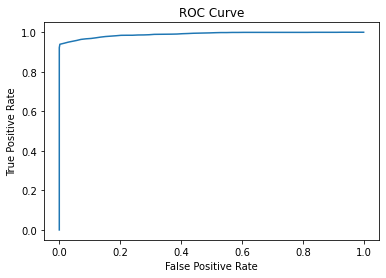

AreaUnderROC: 0.9899780703127122


In [80]:
overallsummary = lr_model.summary
roc = overallsummary.roc.toPandas()
plt.plot(roc['FPR'],roc['TPR'])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.title('ROC Curve')
plt.show()
print('AreaUnderROC: ' + str(overallsummary.areaUnderROC))

**Random Forest Classifier**

In [81]:
from pyspark.ml.classification import RandomForestClassifier
rf= RandomForestClassifier(featuresCol = 'features', labelCol = 'cardiac_arrest')
rf_model= rf.fit(train_df)
y_pred_rf= rf_model.transform(test_df)
y_pred_rf.select('prediction','cardiac_arrest').show(5)
rf_accuracy = evaluatorMulti.evaluate(y_pred_rf)
print('test_error = %g' % (1-rf_accuracy))
print('Accuracy = %g' % rf_accuracy) 

+----------+--------------+
|prediction|cardiac_arrest|
+----------+--------------+
|       0.0|           0.0|
|       0.0|           0.0|
|       0.0|           0.0|
|       0.0|           0.0|
|       0.0|           0.0|
+----------+--------------+
only showing top 5 rows

test_error = 0.18698
Accuracy = 0.81302


In [82]:
#from pyspark.ml.evaluation import MulticlassClassificationEvaluator
rf_acc = evaluatorMulti.evaluate(y_pred_rf, {evaluatorMulti.metricName: "accuracy"})
rf_f1 = evaluatorMulti.evaluate(y_pred_rf, {evaluatorMulti.metricName: "f1"})
rf_auroc = evaluator.evaluate(y_pred_rf, {evaluator.metricName: "areaUnderROC"})

print('Random Forest algorithm has an accuracy of: {0:2.2f}%'.format(rf_acc*100))
print('Random Forest algorithm has an F1_Score: {0:2.2f}%'.format(rf_f1*100))
print("Area under ROC Curve: {0:2.2f}".format(rf_auroc*100))

Random Forest algorithm has an accuracy of: 81.31%
Random Forest algorithm has an F1_Score: 81.30%
Area under ROC Curve: 89.55


**GBT Classifier**

In [88]:
from pyspark.ml.classification import GBTClassifier
gbt = GBTClassifier(featuresCol = 'features', labelCol = 'cardiac_arrest',maxIter=10)
gbt_model = gbt.fit(train_df)
y_pred_gbt = gbt_model.transform(test_df)

#evaluating
gbt_acc = evaluatorMulti.evaluate(y_pred_gbt, {evaluatorMulti.metricName: "accuracy"})
gbt_f1 = evaluatorMulti.evaluate(y_pred_gbt, {evaluatorMulti.metricName: "f1"})
gbt_auroc = evaluator.evaluate(y_pred_gbt, {evaluator.metricName: "areaUnderROC"})

print('Gradient Boosted Tree algorithm has an accuracy of: {0:2.2f}%'.format(gbt_acc*100))
print('Gradient Boosted algorithm has an F1_Score: {0:2.2f}%'.format(gbt_f1*100))
print("Area under ROC Curve: {0:2.2f}%".format(gbt_auroc*100))

Gradient Boosted Tree algorithm has an accuracy of: 95.02%
Gradient Boosted algorithm has an F1_Score: 95.02%
Area under ROC Curve: 98.67%


In [84]:
print(gbt.explainParams())

cacheNodeIds: If false, the algorithm will pass trees to executors to match instances with nodes. If true, the algorithm will cache node IDs for each instance. Caching can speed up training of deeper trees. Users can set how often should the cache be checkpointed or disable it by setting checkpointInterval. (default: False)
checkpointInterval: set checkpoint interval (>= 1) or disable checkpoint (-1). E.g. 10 means that the cache will get checkpointed every 10 iterations. Note: this setting will be ignored if the checkpoint directory is not set in the SparkContext. (default: 10)
featureSubsetStrategy: The number of features to consider for splits at each tree node. Supported options: 'auto' (choose automatically for task: If numTrees == 1, set to 'all'. If numTrees > 1 (forest), set to 'sqrt' for classification and to 'onethird' for regression), 'all' (use all features), 'onethird' (use 1/3 of the features), 'sqrt' (use sqrt(number of features)), 'log2' (use log2(number of features)), 

In [87]:
#applying paramgrid builder and crossvalidator for optimal result
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator
paramGrid = (ParamGridBuilder()
             .addGrid(gbt.maxDepth, [2, 4, 6])
             .addGrid(gbt.maxBins, [20, 60])
             .addGrid(gbt.maxIter, [10, 20])
             .build())
cv = CrossValidator(estimator=gbt, estimatorParamMaps=paramGrid, evaluator=evaluator, numFolds=5)

cv_model = cv.fit(train_df)
y_pred_gbtcv = cv_model.transform(test_df)

#evaluation
cv_gbt_acc = evaluatorMulti.evaluate(y_pred_gbtcv, {evaluatorMulti.metricName: "accuracy"})
cv_gbt_f1 = evaluatorMulti.evaluate(y_pred_gbtcv, {evaluatorMulti.metricName: "f1"})
cv_gbt_auroc = evaluator.evaluate(y_pred_gbtcv, {evaluator.metricName: "areaUnderROC"})

print('Hyper Parameter optimized and Cross Validated Gradient Boosted Tree classifier has an accuracy of: {0:2.2f}%'.format(cv_gbt_acc*100))
print('Hyper Parameter optimized and Cross Validated Gradient Boosted Tree classifier has an F1_Score: {0:2.2f}%'.format(cv_gbt_f1*100))
print("Area under ROC Curve: {0:2.2f}%".format(cv_gbt_auroc*100))

Hyper Parameter optimized and Cross Validated Gradient Boosted Tree classifier has an accuracy of: 96.11%
Hyper Parameter optimized and Cross Validated Gradient Boosted Tree classifier has an F1_Score: 96.10%
Area under ROC Curve: 99.11%


Hyper Parameter optimized and Cross Validated Gradient Boosted Tree classifier has an accuracy of: 96.11% .
Hyper Parameter optimized and Cross Validated Gradient Boosted Tree classifier has an F1_Score: 96.10% .
Area under ROC Curve: 99.11 % .


# Redundant

In [ ]:
# from pyspark.ml import Pipeline
# from pyspark.ml.feature import StringIndexer, OneHotEncoder, VectorAssembler

# categorical_columns= ["gender", "ever_married","work_type","Residence_type","smoking_status"]

# # The index of string values multiple columns
# indexers = [
#     StringIndexer(inputCol=c, outputCol="{0}_indexed".format(c))
#     for c in categorical_columns
# ]

# # The encode of indexed values multiple columns
# encoders = [OneHotEncoder(dropLast=False,inputCol=indexer.getOutputCol(),
#             outputCol="{0}_encoded".format(indexer.getOutputCol())) 
#     for indexer in  indexers
# ]

# # Vectorizing encoded values
# assembler = VectorAssembler(inputCols=([encoder.getOutputCol() for encoder in encoders]+numeric_col),outputCol="features")

# pipeline = Pipeline(stages=indexers + encoders+[assembler])
# model=pipeline.fit(df)
# df_new= model.transform(df)